# Тренеровка модели и получение предварительных данных
Этот код являеться все целой копии "Basic tutorial for query to reference maping using expiMap" с небольшими доработками чтобы скрипт мог работать с иным набором данных.

In [24]:
import warnings
warnings.simplefilter(action='ignore')

import scanpy as sc
import torch
import scarches as sca
import numpy as np
import gdown

In [25]:
sc.set_figure_params(frameon=False)
sc.set_figure_params(dpi=200)
sc.set_figure_params(figsize=(4, 4))
torch.set_printoptions(precision=3, sci_mode=False, edgeitems=7)

Скрипт производить иницилизацию библеотек, а также в каком формате должен работать scanpy при создании фигур.

In [26]:
url = 'https://drive.google.com/uc?id=1mJ8nYnDQdDUivZpAFIPoNPMppOUCRAPT'
output = 'tyser.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1mJ8nYnDQdDUivZpAFIPoNPMppOUCRAPT
To: /home/luna/Desktop/in-house/scripts/tyser.h5ad
100%|██████████| 46.2M/46.2M [00:03<00:00, 14.4MB/s]


'tyser.h5ad'

In [27]:
adata = sc.read('tyser.h5ad')

In [28]:
url = 'https://drive.google.com/uc?id=1JGatjjXPXKZza5ksOWYHD2kJvUSDZG-0'
output = 'hiPSC.h5ad'
gdown.download(url, output, quiet=False)

Downloading...
From (original): https://drive.google.com/uc?id=1JGatjjXPXKZza5ksOWYHD2kJvUSDZG-0
From (redirected): https://drive.google.com/uc?id=1JGatjjXPXKZza5ksOWYHD2kJvUSDZG-0&confirm=t&uuid=a217cc8c-2044-4003-9ac0-75731d2008ba
To: /home/luna/Desktop/in-house/scripts/hiPSC.h5ad
100%|██████████| 133M/133M [00:10<00:00, 12.2MB/s] 


'hiPSC.h5ad'

In [29]:
hips =  sc.read("hiPSC.h5ad")

In [30]:
adata

AnnData object with n_obs × n_vars = 1069 × 57490
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'Source.Name', 'Characteristics.sampling.site.', 'Characteristics.inferred.cell.type...authors.labels.', 'Characteristics.inferred.cell.type...ontology.labels.', 'cluster_id', 'sub_cluster', 'origin', 'run', 'sample_name', 'timepoint', 'percent.mt'
    var: 'features'

In [31]:
url = 'https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c'
output = 'reactome.gmt'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1136LntaVr92G1MphGeMVcmpE0AqcqM6c
To: /home/luna/Desktop/in-house/scripts/reactome.gmt
100%|██████████| 331k/331k [00:00<00:00, 8.37MB/s]


'reactome.gmt'

In [32]:
sca.utils.add_annotations(adata, 'reactome.gmt', min_genes=12, clean=True)
adata._inplace_subset_var(adata.varm['I'].sum(1)>0)

sc.pp.normalize_total(adata)
sc.pp.log1p(adata)

sc.pp.highly_variable_genes(
    adata,
    n_top_genes=2000,
    batch_key="sample_name",
    subset=True)

In [33]:
select_terms = adata.varm['I'].sum(0) > 12

adata.uns['terms'] = np.array(adata.uns['terms'])[select_terms].tolist()
adata.varm['I'] = adata.varm['I'][:, select_terms]

adata._inplace_subset_var(adata.varm['I'].sum(1) > 0)

In [34]:
# Шаг 1: Получить список генов из var
var_genes = adata.var.index.tolist()

# Шаг 2: Найти соответствующий столбец с названиями генов в raw.var
# Предположим, что столбец называется '_index'
if '_index' not in adata.raw.var.columns:
    raise ValueError("В raw.var отсутствует столбец с названиями генов (например, '_index')")

raw_gene_names = adata.raw.var['_index'].tolist()

# Шаг 3: Найти индексы генов из var в raw.var
selected_raw_indices = [i for i, gene in enumerate(raw_gene_names) if gene in var_genes]

# Шаг 4: Извлечь данные из raw.X для нужных генов
raw_X = adata.raw.X
if isinstance(raw_X, np.ndarray):  # Если raw.X в формате numpy массива
    filtered_raw_X = raw_X[:, selected_raw_indices]
else:  # Если raw.X разреженная матрица
    filtered_raw_X = raw_X[:, selected_raw_indices].toarray()

# Шаг 5: Заменить X данными из raw.X
adata.X = filtered_raw_X

# Шаг 6: Обновить var, чтобы он соответствовал данным
filtered_var = adata.raw.var.iloc[selected_raw_indices]
filtered_var.index = var_genes  # Присваиваем оригинальный индекс var
adata.var = filtered_var


In [35]:
commom = adata.var_names.intersection(hips.var_names)
hips = hips[:, commom].copy()
adata = adata[:, commom].copy()

In [36]:

intr_cvae = sca.models.EXPIMAP(
    adata=adata,
    condition_key='sample_name',
    hidden_layer_sizes=[256, 256, 256],
    recon_loss='nb'
)


INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1841 256 1
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 224
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  224 0 0 1 1841
	with hard mask.
Last Decoder layer: softmax


In [37]:
ALPHA = 0.7

adata.X = adata.X.astype(np.float32)

In [38]:
early_stopping_kwargs = {
    "early_stopping_metric": "val_unweighted_loss", # val_unweighted_loss
    "threshold": 0,
    "patience": 50,
    "reduce_lr": True,
    "lr_patience": 13,
    "lr_factor": 0.1,
}
intr_cvae.train(
    n_epochs=400,
    alpha_epoch_anneal=100,
    alpha=ALPHA,
    alpha_kl=0.5,
    weight_decay=0.,
    early_stopping_kwargs=early_stopping_kwargs,
    use_early_stopping=True,
    monitor_only_val=False,
    seed=2020,
)

Preparing (1069, 1841)
Instantiating dataset
Init the group lasso proximal operator for the main terms.
 |████████████████████| 100.0%  - epoch_loss: 2867.4158630371 - epoch_recon_loss: 2726.1680908203 - epoch_kl_loss: 282.4955558777 - val_loss: 3090.4028320312 - val_recon_loss: 2953.9746093750 - val_kl_loss: 272.85656738281
Saving best state of network...
Best State was in Epoch 399


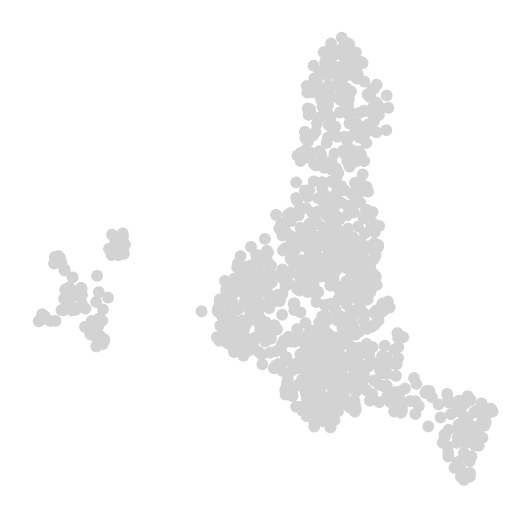

In [39]:
MEAN = False
adata.obsm['X_cvae'] = intr_cvae.get_latent(mean=MEAN, only_active=True)
sc.pp.neighbors(adata, use_rep='X_cvae')
sc.tl.umap(adata)


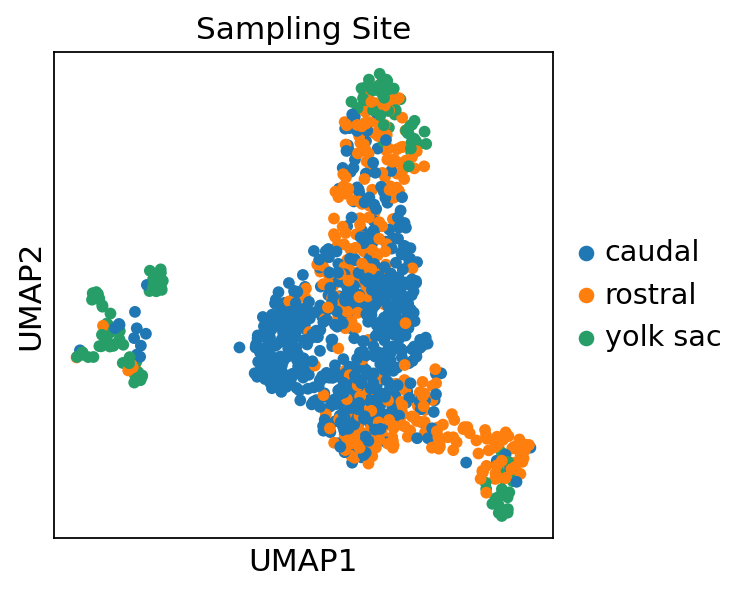

In [45]:
sc.pl.umap(adata,color=['Characteristics.sampling.site.'],title=["Sampling Site"], frameon=True)

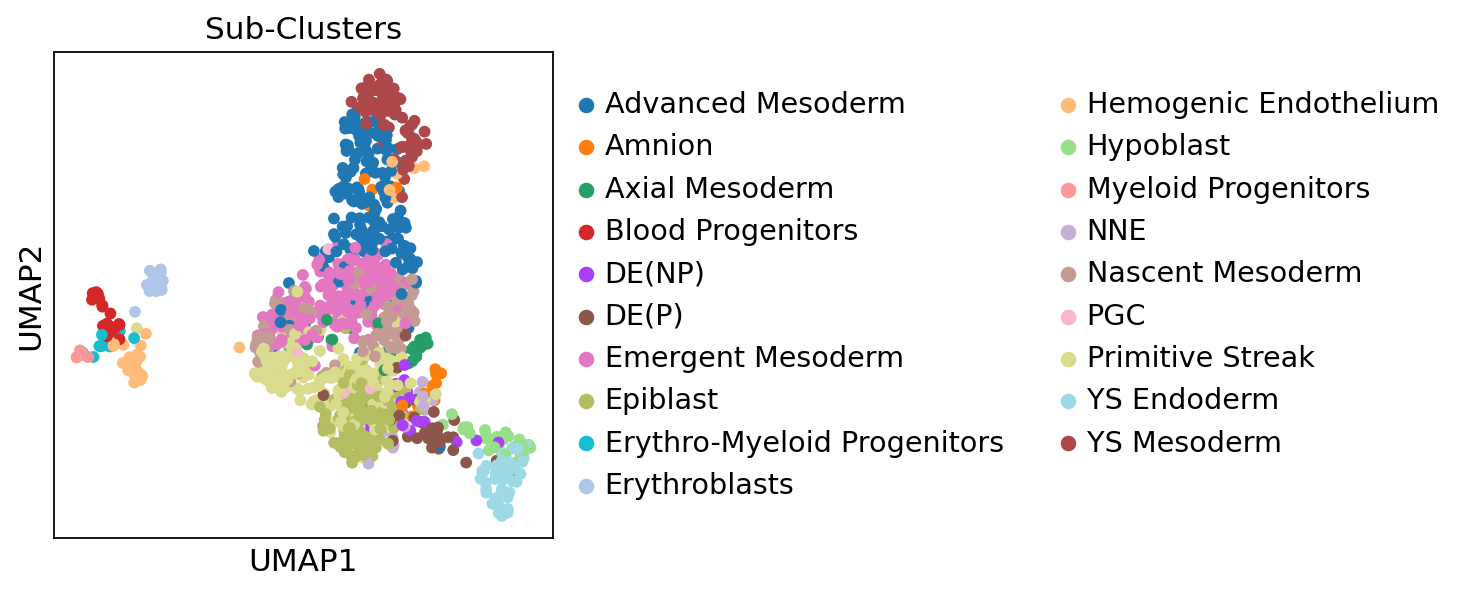

In [46]:
sc.pl.umap(adata,color=['sub_cluster'], title=["Sub-Clusters"],frameon=True)


In [50]:
hips.X = hips.X.astype(np.float32)

hips.obs = hips.obs.rename(columns={"sample_id":"sample_name"})

In [51]:
hips.uns['terms'] = adata.uns['terms']

In [52]:
q_intr_cvae = sca.models.EXPIMAP.load_query_data(hips, intr_cvae)

q_intr_cvae.train(n_epochs=400, alpha_epoch_anneal=100, weight_decay=0., alpha_kl=0.1, seed=2020, use_early_stopping=True)


AnnData object with n_obs × n_vars = 4694 × 1841
    obs: 'orig.ident', 'nCount_RNA', 'nFeature_RNA', 'run', 'sample_name', 'percent.mt', 'percent.dissoc', 'RNA_snn_res.0.3', 'seurat_clusters', 'RNA_snn_res.0.22'
    var: 'features'
    uns: 'neighbors', 'terms'
    obsm: 'X_mnn', 'X_umap'
    obsp: 'distances'

INITIALIZING NEW NETWORK..............
Encoder Architecture:
	Input Layer in, out and cond: 1841 256 5
	Hidden Layer 1 in/out: 256 256
	Hidden Layer 2 in/out: 256 256
	Mean/Var Layer in/out: 256 224
Decoder Architecture:
	Masked linear layer in, ext_m, ext, cond, out:  224 0 0 5 1841
	with hard mask.
Last Decoder layer: softmax
Preparing (4694, 1841)
Instantiating dataset
 |█████████████-------| 67.8%  - val_loss: 1174.9747619629 - val_recon_loss: 1162.5174865723 - val_kl_loss: 124.5729141235
ADJUSTED LR
 |██████████████------| 72.0%  - val_loss: 1173.1753234863 - val_recon_loss: 1160.7290039062 - val_kl_loss: 124.4629535675
ADJUSTED LR
 |██████████████------| 73.8%  - val_loss

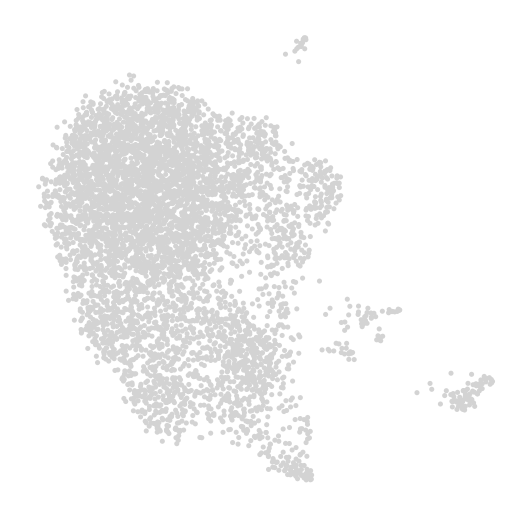

In [53]:
dataset_samen = sc.AnnData.concatenate(adata, hips, batch_key='batch_join', uns_merge='same')

dataset_samen.X = dataset_samen.X.astype(np.float32)

dataset_samen.obsm['X_cvae'] = q_intr_cvae.get_latent(dataset_samen.X, dataset_samen.obs['sample_name'], mean=MEAN, only_active=True)
sc.pp.neighbors(dataset_samen, use_rep='X_cvae')
sc.tl.umap(dataset_samen)

dataset_samen

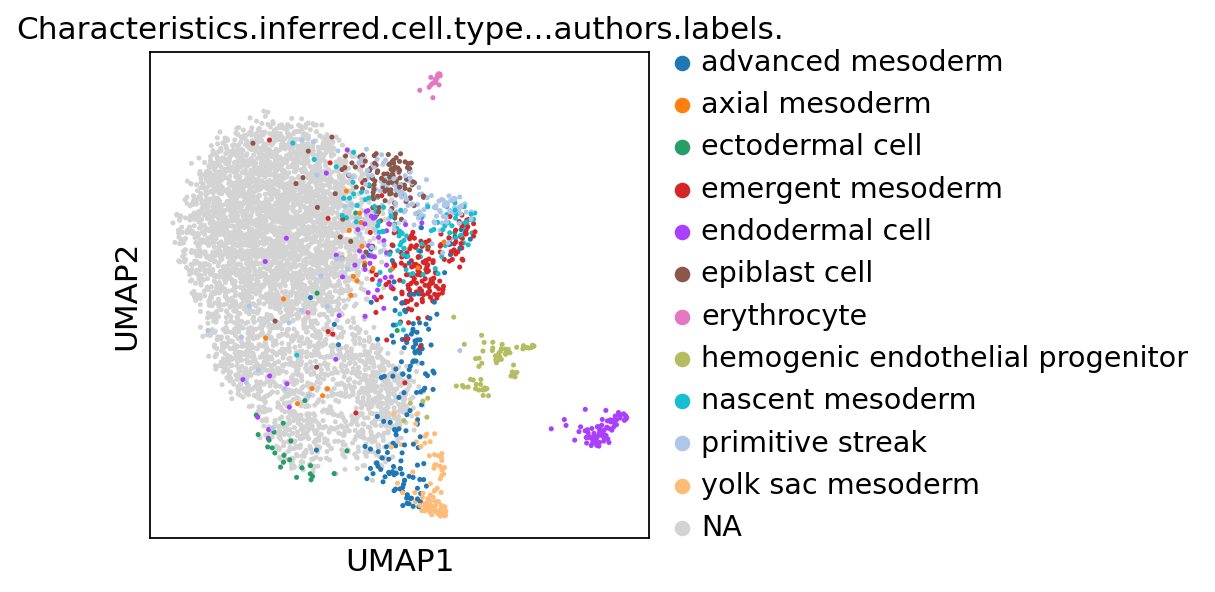

In [54]:
sc.pl.umap(dataset_samen, color=['Characteristics.inferred.cell.type...authors.labels.'], title = ["Cell type"]frameon=True, wspace=0.6)

In [ ]:
q_intr_cvae.latent_directions(adata=dataset_samen)
q_intr_cvae.latent_enrich(groups='sample_name', comparison='rest', use_directions=True, adata=dataset_samen)


In [ ]:
fig = sca.plotting.plot_abs_bfs(dataset_samen, yt_step=0.8, scale_y=2.5, fontsize=7)